# Bärlauch - Maiglöckchen Classifier

In [1]:
from utils import *
from fastai2.vision.widgets import *

## Make the dataset

In [2]:
key = '30f5c20e2b8f422ca71456fd45afd3f0'

In [3]:
plant_dict = {'baerlauch': 'Allium ursinum', 'maigloeckchen':'convallaria majalis'}

In [5]:
path = Path('plants')

In [5]:
if not path.exists():
    path.mkdir()
    for o in plant_dict.keys():
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{plant_dict[o]}')
        download_images(dest, urls=results.attrgot('content_url'))

In [6]:
fns = get_image_files(path)
fns

(#297) [Path('plants/baerlauch/00000143.jpg'),Path('plants/baerlauch/00000111.jpg'),Path('plants/baerlauch/00000065.jpg'),Path('plants/baerlauch/00000035.jpg'),Path('plants/baerlauch/00000147.jpg'),Path('plants/baerlauch/00000118.jpg'),Path('plants/baerlauch/00000039.jpg'),Path('plants/baerlauch/00000059.jpg'),Path('plants/baerlauch/00000087.jpg'),Path('plants/baerlauch/00000084.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#4) [Path('plants/baerlauch/00000045.jpg'),Path('plants/maigloeckchen/00000133.jpg'),Path('plants/maigloeckchen/00000130.jpg'),Path('plants/maigloeckchen/00000086.jpg')]

In [8]:
failed.map(Path.unlink);

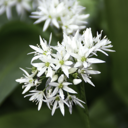

In [10]:
im = Image.open('plants/baerlauch/00000120.jpg')
im.to_thumb(128,128)

## Train a model

In [6]:
plants = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [7]:
dls = plants.dataloaders(path)

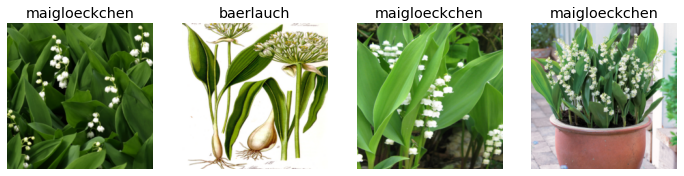

In [8]:
dls.valid.show_batch(max_n=4, nrows=1)

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.128754,0.482169,0.224138,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.622189,0.391320,0.206897,00:05
1,0.538585,0.384510,0.172414,00:04
2,0.425374,0.383581,0.137931,00:05
3,0.351477,0.363520,0.137931,00:04


## Analyse predictions

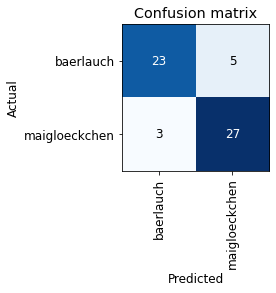

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

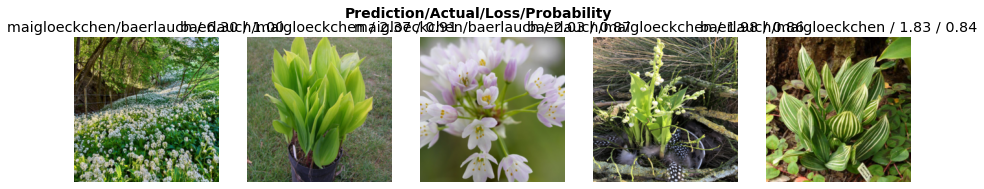

In [11]:
interp.plot_top_losses(5, nrows=1)

In [12]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [13]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)

## Turning it into a webapp

### Model for inference

In [14]:
learn.export()

In [15]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [16]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
learn_inf.predict('plants/maigloeckchen/00000003.jpg')

('maigloeckchen', tensor(1), tensor([0.0126, 0.9874]))

In [19]:
learn_inf.dls.vocab

(#2) ['baerlauch','maigloeckchen']

### Make a notebook app

In [32]:
# btn_upload = widgets.FileUpload()
# btn_upload

FileUpload(value={}, description='Upload')

In [33]:
# img = PILImage.create(btn_upload.data[-1])

In [20]:
out_pl = widgets.Output()
out_pl.clear_output()
# with out_pl: display(img.to_thumb(128,128))
# out_pl

In [21]:
# pred,pred_idx,probs = learn_inf.predict(img)

In [22]:
lbl_pred = widgets.Label()
# lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
# lbl_pred

In [23]:
btn_run = widgets.Button(description='Classify')
# btn_run

In [24]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [25]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [26]:
VBox([widgets.Label('Select your plant!'), 
      btn_upload, btn_run, out_pl, lbl_pred])